In [11]:

import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import  gym
#import gym
#from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score


#from google.colab import drive
#drive.mount('/content/drive')


# Assuming the file is directly in your main Google Drive folder
file_path = 'C:/Users/ashwi/Downloads/archive (3)/blackjack_simulator.csv'
data = pd.read_csv(file_path, sep=',', nrows=100000)


In [13]:
def predict_action(dealer_card, player_total, player_has_ace, model):
    """Predicts the best action ('Hit' or 'Stand') based on the model and plots the results."""
    input_features = pd.DataFrame({
        'dealer_card': [dealer_card],
        'player_total': [player_total],
        'player_ace': [1 if player_has_ace else 0]
    })
    action_prob = model.predict_proba(input_features)[0]
    actions = ['Hit', 'Stand']
    action = actions[model.predict(input_features)[0]]

    # Output the recommended action
    print(f"Recommended action: {action}")
    print(f"Probability of 'Hit': {action_prob[0]:.2f}")
    print(f"Probability of 'Stand': {action_prob[1]:.2f}")

    # Plotting the probabilities as a bar chart
    plt.figure(figsize=(8, 4))
    sns.barplot(x=actions, y=action_prob, color='mediumturquoise')  # Specify a single color or different colors for each bar
    plt.title('Action Probabilities')
    plt.ylabel('Probability')
    plt.show()

    # Pie chart visualization of probabilities
    plt.figure(figsize=(6, 6))
    plt.pie(action_prob, labels=actions, autopct='%1.1f%%', startangle=90, colors=['tomato', 'mediumseagreen'])
    plt.title('Action Distribution')
    plt.show()


In [14]:
# Load and prepare the dataset
file_path = 'C:/Users/ashwi/Downloads/archive (3)/blackjack_simulator.csv'
data = pd.read_csv(file_path, sep=',', nrows=100000)
data['initial_hand'] = data['initial_hand'].apply(eval)
data['dealer_final'] = data['dealer_final'].apply(eval)
data['player_final'] = data['player_final'].apply(eval)
data['actions_taken'] = data['actions_taken'].apply(eval)
data = data.explode('player_final')
data['actions_taken'] = data['actions_taken'].apply(lambda x: [item for sublist in x for item in (sublist if isinstance(sublist, list) else [sublist])])
data = data.explode('actions_taken')

In [15]:
# Filter for 'H' and 'S' actions
data = data[data['actions_taken'].isin(['H', 'S'])]
data['action_binary'] = data['actions_taken'].apply(lambda x: 1 if x == 'S' else 0)

# Prepare features and target variable
features = pd.DataFrame({
    'dealer_card': data['dealer_up'],
    'player_total': data['player_final'].apply(lambda hand: sum(hand) if isinstance(hand, list) else hand),
    'player_ace': data['player_final'].apply(lambda hand: 1 if 11 in hand else 0)
})
target = data['action_binary']

In [16]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
acclist = []
perlist = []


KNNlist = [x for x in range(1,26,2)]

for k in KNNlist:
# Initialize and fit the K-Nearest Neighbors (KNN) classifier
    model = KNeighborsClassifier(n_neighbors=k)  # You can adjust the number of neighbors (k) as needed
    model.fit(X_train, y_train)
    # Predictions and evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    percision = precision_score(y_test,y_pred,average='weighted')
    acclist.append(accuracy)
    perlist.append(percision)

totalscore = pd.DataFrame({'Accuracy' : acclist , 'Percision' : perlist} , index = KNNlist)
totalscore

,Accuracy,Percision
1,0.719419,0.718034
3,0.727450,0.725350
5,0.741199,0.739687
7,0.743065,0.741781
9,0.749392,0.748469
11,0.762411,0.764344
13,0.753853,0.753222
15,0.770279,0.775361
17,0.770604,0.779392
19,0.771415,0.779530


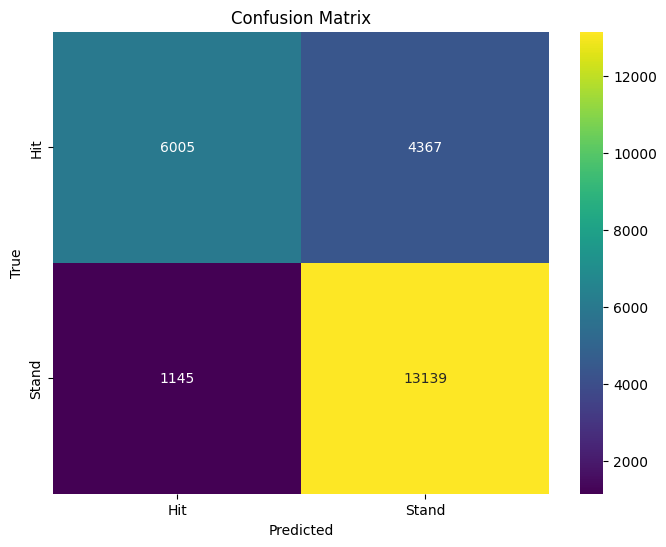

In [17]:





# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Hit', 'Stand'], yticklabels=['Hit', 'Stand'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




Model Interpretation:

The model's accuracy of 77.64% indicates its effectiveness in predicting the correct actions ('Hit' or 'Stand').

This suggests the KNN model's ability to capture the underlying patterns based on the features provided.
Recommended action: Stand
Probability of 'Hit': 0.36
Probability of 'Stand': 0.64


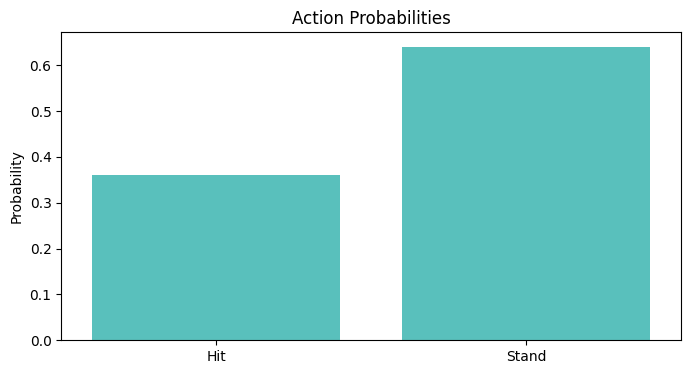

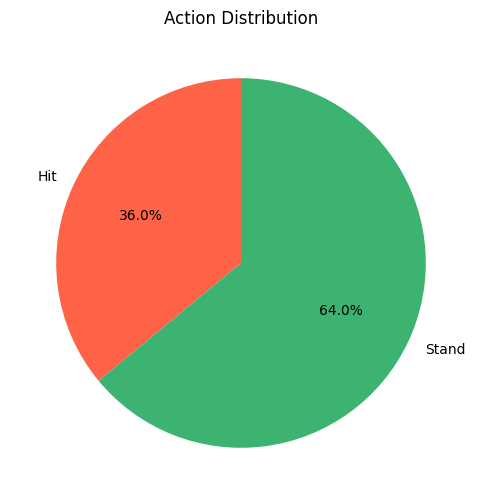

Recommended action: Stand
Probability of 'Hit': 0.08
Probability of 'Stand': 0.92


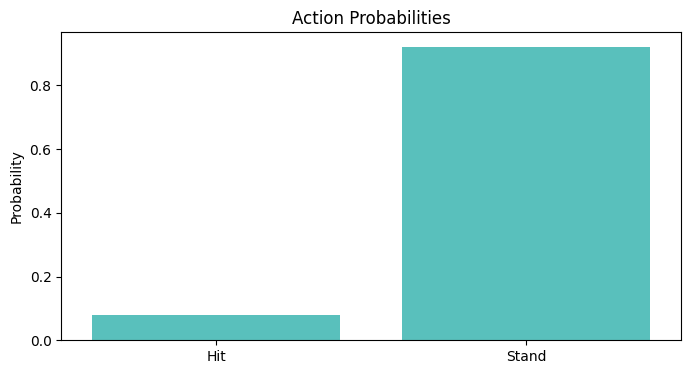

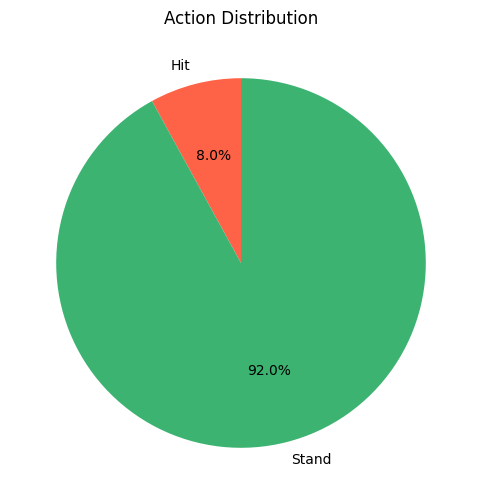

In [18]:
# Interpretation of the model's performance
print("Model Interpretation:\n")
print("The model's accuracy of {:.2f}% indicates its effectiveness in predicting the correct actions ('Hit' or 'Stand').".format(accuracy_score(y_test, y_pred) * 100))
print("\nThis suggests the KNN model's ability to capture the underlying patterns based on the features provided.")

# Example predictions
predict_action(10, 15, False, model)  # Example where dealer shows 10 and player has total 15 without an ace
predict_action(6, 12, True, model)    # Example where dealer shows 6 and player has total 12 with an ace




In [19]:
from tqdm import tqdm
env = gym.make("Blackjack-v1", sab=True)

n_episodes = 500_000 #play 500000 games

done = False
obs, info = env.reset()

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
win, lose, even = 0, 0, 0

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    
    # play one episode
    while not done:
        action = 0 # <- 0(stay) or 1(hit) using your model to give the action
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update if the environment is done and the current obs
        done = terminated or truncated
        if done:
          if reward > 0:
              win += 1
          elif reward < 0:
              lose += 1
          else:
              even += 1
        obs = next_obs

total_game = win + lose + even

print("Win: {}\t({}%)\nLose: {}\t({}%)\nEven: {}\t({}%)\n".format(win, win/total_game*100, lose, lose/total_game*100, even, even/total_game*100))

  0%|          | 0/500000 [00:00<?, ?it/s]c:\Users\ashwi\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 500000/500000 [00:35<00:00, 13933.01it/s]

Win: 191648	(38.3296%)
Lose: 283998	(56.7996%)
Even: 24354	(4.8708%)

